In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import Model,layers
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [2]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 10)
Y = 0.5 + np.dot(X, [1.5, -2., 0.0001,3.,10.,-0.55,8.,6.,1.,0.05])

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2) # Generating train and test dataset

min_val_x = X.min()
max_val_x = X.max()

min_val_y = Y.min()
max_val_y = Y.max()

X_train = (X_train - min_val_x) / (max_val_x - min_val_x)
X_test = (X_test - min_val_x) / (max_val_x - min_val_x)

Y_train = (Y_train - min_val_y) / (max_val_y - min_val_y)
Y_test = (Y_test - min_val_y) / (max_val_y - min_val_y)

print(X_train.shape, Y_train.shape)

(80, 10) (80,)


with noise

In [3]:
mu=0.0
std = 0.20 * np.std(X_train) # for %20 Gaussian noise
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_n = x + noise
    return x_n 

X_train_n = gaussian_noise(X_train,mu,std)
X_test_n = gaussian_noise(X_test,mu,std)

In [4]:
model = Sequential()
model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_normal', input_shape = (X_train.shape[1],)))
model.add(Dense(8, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(1))

In [5]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = 'mae')

history = model.fit(X_train, Y_train, epochs=500)

loss, mae = model.evaluate(X_test, Y_test)
loss_n,mae_n = model.evaluate(X_test_n,Y_test)

Epoch 1/500
3/3 [==============================] - 0s 2ms/step - loss: 1.0983 - mae: 1.0098
Epoch 2/500
3/3 [==============================] - 0s 0s/step - loss: 0.9647 - mae: 0.9440
Epoch 3/500
3/3 [==============================] - 0s 8ms/step - loss: 0.8417 - mae: 0.8794
Epoch 4/500
3/3 [==============================] - 0s 0s/step - loss: 0.7345 - mae: 0.8185
Epoch 5/500
3/3 [==============================] - 0s 0s/step - loss: 0.6399 - mae: 0.7597
Epoch 6/500
3/3 [==============================] - 0s 0s/step - loss: 0.5550 - mae: 0.7042
Epoch 7/500
3/3 [==============================] - 0s 8ms/step - loss: 0.4815 - mae: 0.6517
Epoch 8/500
3/3 [==============================] - 0s 0s/step - loss: 0.4145 - mae: 0.6011
Epoch 9/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3560 - mae: 0.5526
Epoch 10/500
3/3 [==============================] - 0s 0s/step - loss: 0.3053 - mae: 0.5078
Epoch 11/500
3/3 [==============================] - 0s 8ms/step - loss: 0.2604 - mae:

In [6]:
history_n = model.fit(X_train_n, Y_train, epochs = 500, verbose=0)
loss_n2, mae_n2 = model.evaluate(X_test,Y_test)
loss_n1,mae_n1 = model.evaluate(X_test_n,Y_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.0107 - mae: 0.0826


In [7]:
latent_space_weights = model.layers[1].get_weights()[0]
latent_space_bias  = model.layers[1].get_weights()[1]
weights = np.append(latent_space_bias[0],latent_space_weights[:,0])

print(weights)

[-0.04459765  0.49064693 -0.18506545  0.05879327  0.89807665  0.18715651
  0.19493283 -0.03101794  0.11972971 -0.22555986  0.1790351  -0.6253892
  0.26756668  0.09131245 -0.5689175  -0.19244604 -0.0684584 ]


In [8]:
np.set_printoptions(threshold=np.inf)

hidden_layaers = keras.backend.function(
[model.layers[0].input],
[model.layers[0].output,] 
)

a = np.array(hidden_layaers([X_train])).reshape(80,16)
X_new = a[0,:]
aa = X_new[0]
print(a.shape)

get_8th_layer_output = K.function([model.layers[0].input], [model.layers[1].output])
hidden_layer_output = get_8th_layer_output([X_train])[0]

Y_new = hidden_layer_output[:,0]
print(Y_new.shape)

le = Lasso(alpha=0.001,max_iter=5000)
le.fit(a,hidden_layer_output)
print(le.coef_.T,le.intercept_)

(80, 16)
(80,)
[[ 0.43538496 -0.20142959 -0.          0.11687309 -0.42831197 -0.09776349
  -0.08490457  0.64178133]
 [-0.20846498 -0.02863076  0.4282363  -0.10858114 -0.         -0.38376194
   0.4639828  -0.03861752]
 [ 0.05784106  0.11596218 -0.065527    0.06580551 -0.         -0.17863694
   0.01613957 -0.04658325]
 [ 0.8120627  -0.16459064 -0.40397486 -0.01469484  0.15509921  0.02522924
   0.5236064   0.12453867]
 [ 0.15321311 -0.43890136  0.14816076 -0.54795796  0.21802104 -0.25820675
   0.2034209   0.4714536 ]
 [ 0.12809889  0.06765994  0.22381578 -0.03421715 -0.50586    -0.13863792
   0.          0.36529627]
 [-0.         -0.16018783  0.11433794 -0.03076503 -0.55388343 -0.00184407
  -0.16563202 -0.43398154]
 [ 0.          0.07151664  0.26003465 -0.          0.         -0.07880964
  -0.          0.20520988]
 [-0.2036527  -0.10503339  0.17807472  0.6130325  -0.18140803 -0.01091815
   0.6059138   0.15954205]
 [ 0.          0.          0.          0.          0.          0.
   0.     

In [9]:
import copy
class Lasso_6:

    def __init__(self, alpha, epoch = 50, weights = np.zeros(17,)):
        self.alpha = alpha  # tuning parameter(penalty term)  
        self.epoch =  epoch  # No. of iterations (default = 1000)
        self.coef = None    # Weights or Co-eficients
        self.bias = None    # Bias or intercept
        self.weights = weights

    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0


    def fit(self, X, y):
            X = np.column_stack((np.ones(len(X)), X))   # Training features
            n = X.shape[0]
            beta = copy.deepcopy(self.weights) # array of bias and weights
            beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])

            for iteration in range(self.epoch):                                         
                for j in range(1,17):                        
                        beta[j] = 0.0                       
                        error  = y - np.dot(X,beta)                                              
                        rho = np.dot(X[:,j], error )                        
                        lamda  = self.alpha*n

                        beta[j] = self.soft_threshold(rho , lamda ) / ((X[:, j]**2).sum()+1e-20) 
                        
                        beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])
            
            self.coef = beta[1:]
            self.bias = beta[0]                   
                
            return self

In [10]:
coeff = np.zeros((16,8))
bias = np.zeros(8)

#for loop over the neurons:
for i in range (hidden_layer_output.shape[1]):
    weights_l = np.append(latent_space_bias[i],latent_space_weights[:,i])
    model_l = Lasso_6(alpha=0.001,epoch=1000,weights=weights_l)
    model_l.fit(a,hidden_layer_output[:,i])
    coeff[:,i]= model_l.coef
    bias[i] = model_l.bias

print(coeff,bias)


[[ 0.43554944 -0.20135055  0.          0.11671109 -0.42840153 -0.09780651
  -0.08502123  0.64175367]
 [-0.2083488  -0.02853689  0.42813179 -0.10883586  0.         -0.38382584
   0.46376863 -0.0386603 ]
 [ 0.05772162  0.11584782 -0.06536835  0.06612629  0.         -0.17856258
   0.01639658 -0.0465074 ]
 [ 0.81215638 -0.16454613 -0.40394092 -0.01477286  0.15508462  0.02521072
   0.5235455   0.12451976]
 [ 0.15327752 -0.43881029  0.14816692 -0.54824674  0.21825691 -0.25826389
   0.20323232  0.47137088]
 [ 0.12803431  0.06760647  0.22390231 -0.03409837 -0.50571948 -0.13859063
   0.          0.36530596]
 [ 0.         -0.16009164  0.11432134 -0.03118246 -0.55347264 -0.00193125
  -0.16594425 -0.43407351]
 [ 0.          0.07161628  0.2601192   0.          0.         -0.07886999
   0.          0.20511676]
 [-0.20371957 -0.10516316  0.178067    0.61345643 -0.1817978  -0.01082665
   0.60622936  0.1596635 ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        

In [11]:
wla = [coeff,bias]
model.layers[1].set_weights(wla)
model.layers[1].trainable = False
model.compile(optimizer='adam',loss='mse',metrics = 'mae')
model.fit(X_train_n,Y_train)
loss_n3,mae_n3 = model.evaluate(X_test,Y_test)
loss_n4,mae_n4 = model.evaluate(X_test_n,Y_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.0055 - mae: 0.0595


In [3]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values

X_A = raw_data[:,:-1]
Y_A = raw_data[:,-1]

Xa_train,Xa_test,Ya_train,Ya_test = train_test_split(X_A,Y_A,test_size=0.2, random_state=21)

min_val = tf.reduce_min(Xa_train)
max_val = tf.reduce_max(Xa_train)

Xa_train = (Xa_train - min_val) / (max_val - min_val)
Xa_test = (Xa_test - min_val) / (max_val - min_val)

Xa_train = tf.cast(Xa_train, tf.float32)
Xa_test = tf.cast(Xa_test, tf.float32)

In [4]:
from keras.callbacks import EarlyStopping
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(20, activation="linear",input_shape=(140,))]) 

        self.decoder = tf.keras.Sequential([
            layers.Dense(32,activation="linear"),
            layers.Activation('relu'),
            layers.Dense(64, activation="relu"),
            layers.Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss='mae')

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
autoencoder.fit(Xa_train,Xa_train,validation_split=0.2,epochs=1000,batch_size=32,verbose=0,callbacks=[early_stop])

re = autoencoder.predict(Xa_test)
test_loss_a = tf.keras.losses.mae(re, Xa_test)
print(np.mean(test_loss_a))


Restoring model weights from the end of the best epoch: 337.
Epoch 357: early stopping
32/32 [==============================] - 0s 1ms/step
0.005325591


In [4]:
re_train = autoencoder.predict(Xa_train)
test_loss_train = tf.keras.losses.mae(re_train, Xa_train)
print(np.mean(test_loss_train))

125/125 [==============================] - 0s 970us/step
0.0052813394


In [ ]:
weight_matrix_latent_to_decoder = autoencoder.decoder.layers[0].get_weights()[0]
bias_matrix_latent_to_decoder = autoencoder.decoder.layers[0].get_weights()[1]
print(weight_matrix_latent_to_decoder)

In [5]:
xa_new = autoencoder.encoder(Xa_train)
print(xa_new.shape)

hidden_layaers_1a = keras.backend.function(
[autoencoder.decoder.layers[0].input],    
[autoencoder.decoder.layers[0].output,] 
)

aa_1 = np.array(hidden_layaers_1a([xa_new])).reshape(3998,32)
print(aa_1)
Ya_new = aa_1[0]

(3998, 20)
[[ 0.26744422  0.55891997  0.38070428 ...  0.23651758 -0.41600615
   0.23978505]
 [ 0.35815355  0.19936179  0.14287336 ...  0.21026611 -0.43172306
   0.25828904]
 [ 0.32474983  0.5666979   0.3416637  ...  0.21180683 -0.35946244
   0.23734158]
 ...
 [ 0.34396482  0.2953583   0.18585521 ...  0.20511869 -0.3988299
   0.26419836]
 [ 0.3650685   0.6176806   0.4258166  ...  0.11260696 -0.3955584
   0.28022105]
 [ 0.2527079   0.37883827  0.3028735  ...  0.2638248  -0.3635211
   0.2097286 ]]


Lasso Scikit learn lib:

In [6]:
la = Lasso(alpha=0.0001,max_iter=1000000)
la.fit(xa_new,aa_1)
w = la.coef_.T
b = la.intercept_
c_w = [w,b]

autoencoder.decoder.layers[0].set_weights(c_w)

#autoencoder.decoder.layers[0].trainable = False  

#autoencoder.compile(optimizer='adam', loss='mse')

#autoencoder.fit(Xa_train,Xa_train,epochs=500,batch_size=32,verbose=0)
re_a = autoencoder.predict(Xa_test)
test_loss_aa = np.mean(tf.keras.losses.mae(re_a, Xa_test))
print(test_loss_aa)



32/32 [==============================] - 0s 3ms/step
0.005442526


In [ ]:
weight_matrix_latent_to_decoder_a = autoencoder.decoder.layers[0].get_weights()[0]
bias_matrix_latent_to_decoder_a = autoencoder.decoder.layers[0].get_weights()[1]
print(weight_matrix_latent_to_decoder_a)


In [7]:
lamda = [0 , 0.0001, 0.001, 0.01, 0.1, 1]
test_loss_aaa = []
test_loss_train = []
w = []

for i in lamda:
    la = Lasso(alpha=i,max_iter=100000)
    la.fit(xa_new,aa_1)
    w = (la.coef_.T)
    b = la.intercept_
    weight_shape = (20, 32)  # Expected shape of the weight
    bias_shape = (32,)
    weight = np.array(w).reshape(weight_shape)
    bias = np.array(b).reshape(bias_shape)
    c_w = [weight, bias]
    

    autoencoder.decoder.layers[0].set_weights(c_w)
    print(f'{i}:{w}')

    #autoencoder.decoder.layers[0].trainable = False  

    #autoencoder.compile(optimizer='adam', loss='mse')

    #autoencoder.fit(Xa_train,Xa_train,epochs=500,batch_size=32,verbose=0)
    re_a = autoencoder.predict(Xa_test)
    test_loss_aaa.append(np.mean(tf.keras.losses.mae(re_a, Xa_test)))  

    re_train = autoencoder.predict(Xa_train)
    test_loss_train = tf.keras.losses.mae(re_train, Xa_train)
    print(np.mean(test_loss_train))  

C:\Users\patel\AppData\Local\Temp\ipykernel_19620\2530756618.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  la.fit(xa_new,aa_1)
e:\Lectures\Arbeit\Sensorics\sens\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


0:[[-4.13608286e-01  4.74992679e-01  3.26849465e-01  6.59126058e-01
  -1.15751005e-01  1.05384152e-01 -5.07301807e-01  2.68677178e-02
  -6.41414883e-02  1.61483247e-02 -2.13837680e-01 -3.64617935e-01
   1.51440246e+00 -2.34530077e-01  6.29801341e-01 -5.65230877e-01
  -1.42600333e-02  4.18037551e-01  1.02390708e+00  5.15905081e-01
   2.35262344e-02 -2.26980277e-01  6.62595304e-01 -3.84207278e-01
   3.14237837e-01  5.08798701e-02  1.17773345e-01  5.65703581e-01
   8.79154086e-02  1.59074730e-01  2.15110871e-01 -7.34322832e-02]
 [ 1.09269654e-02 -2.06759851e-01 -3.89489403e-01  6.07725545e-01
   3.65208818e-02  3.50526032e-01 -3.67623861e-01  3.56084531e-03
  -1.49998441e-01 -4.06996244e-01 -5.67195134e-01 -4.62937307e-02
   2.20087540e-01 -2.43006848e-02 -1.94472188e-01 -1.71583636e-02
   4.93186142e-02  2.35930027e-01  6.19520312e-02  4.84158371e-01
   4.93896527e-01 -1.97144242e-03 -7.34990439e-02 -1.10764924e-01
  -2.34493232e-01 -2.17728576e-01  1.93371953e-02 -9.04654524e-02
   3.22

[0.0053275838, 0.005442526, 0.0072445255, 0.019591725, 0.03206804, 0.03206804]


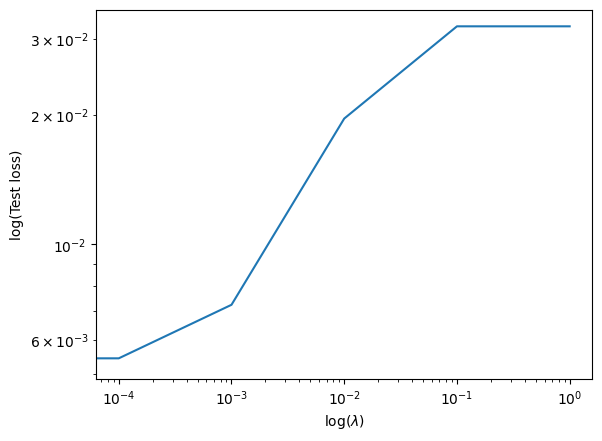

In [9]:
print(test_loss_aaa)
plt.plot(lamda,test_loss_aaa)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(Test loss)')
plt.show()

Lasso with customized code:

In [21]:
class Lasso_6a:

    def __init__(self, alpha, epoch = 1000, weights = np.zeros(17,)):
        self.alpha = alpha  # tuning parameter(penalty term)  
        self.epoch =  epoch  # No. of iterations (default = 1000)
        self.coef = None    # Weights or Co-eficients
        self.bias = None    # Bias or intercept
        self.weights = weights

    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0


    def fit(self, X, y):
            X = np.column_stack((np.ones(len(X)), X))   # Training features
            n = X.shape[0]
            beta = copy.deepcopy(self.weights) # array of bias and weights
            beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])

            for iteration in range(self.epoch):                                         
                for j in range(1,17):                        
                        beta[j] = 0.0                       
                        error  = y - np.dot(X,beta)                       
                        rho = np.dot(X[:,j], error )
                        lamda  = self.alpha*n

                        beta[j] = self.soft_threshold(rho , lamda ) / ((X[:, j]**2).sum()+1e-20) 
                        
                        beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])
            
            self.coef = beta[1:]
            self.bias = beta[0]                   
                
            return self

In [22]:
coeff_a = np.zeros((16,32))
bias_a = np.zeros(32)


for i in range (aa_1.shape[1]):
    weights_a = np.append(bias_matrix_latent_to_decoder[i],weight_matrix_latent_to_decoder[:,i])
    model_a = Lasso_6a(alpha=0.001,epoch=100,weights=weights_a)
    model_a.fit(xa_new,aa_1[:,i])
    coeff_a[:,i]= model_a.coef
    bias_a[i] = model_a.bias
    
wb = [coeff_a,bias_a]   
autoencoder.decoder.layers[0].set_weights(wb)
re_aaa = autoencoder.predict(Xa_test)
test_loss_lasso = (np.mean(tf.keras.losses.mae(re_aaa, Xa_test)))  

32/32 [==============================] - 0s 626us/step


In [23]:
coeff_a = np.zeros((16,32))
bias_a = np.zeros(32)
test_loss_lasso = []

#for loop over the neurons:
for j in lamda:
    for i in range (aa_1.shape[1]):
        weights_a = np.append(bias_matrix_latent_to_decoder[i],weight_matrix_latent_to_decoder[:,i])
        model_a = Lasso_6a(alpha=j,epoch=100,weights=weights_a)
        model_a.fit(xa_new,aa_1[:,i])
        coeff_a[:,i]= model_a.coef
        bias_a[i] = model_a.bias
    
    wb = [coeff_a,bias_a]   
    autoencoder.decoder.layers[0].set_weights(wb)
    re_aaa = autoencoder.predict(Xa_test)
    test_loss_lasso.append(np.mean(tf.keras.losses.mae(re_aaa, Xa_test)))      

32/32 [==============================] - 0s 790us/step


[0.005325243, 0.0053263237, 0.005382058, 0.00715913, 0.017914003, 0.031400297, 0.032134317, 0.032134317]


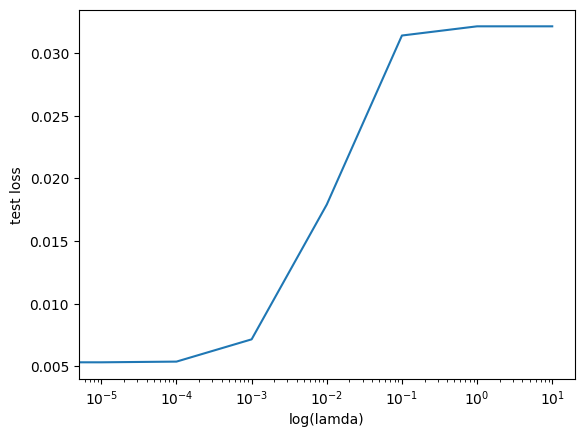

In [24]:
print(test_loss_lasso)
plt.plot(lamda,test_loss_lasso)
plt.xscale("log")
plt.xlabel('log(lamda)')
plt.ylabel('test loss')
plt.show()